# Span Experiments

## Table of Contents

1. [Full Trace Degradation Rate](#Full-Trace-Degradation-Rate)
2. [Effect of Adaptive Sampling Algorithm on Full Trace Degradation Rate](#Effect-of-Adaptive-Sampling-Algorithm-on-Full-Trace-Degradation-Rate)
3. [Trace Compression Ratio](#Trace-Compression-Ratio)
4. [Secondary Sorting Method](#Secondary Sorting Method)

## Reminder

This is a jupyter notebook, and thus has some interactive elements. Please select Cell -> Run All before reading!

## Code

All simulation code can be found on [github](https://github.com/germanjoey/as_binder).

# Full Trace Degradation Rate


## Motivation

Span secondary sorting is a potentially complex operation that would only be necessary if a significant number of traces are clipped from the span reservoir. That means that secondary sorting is intimately conditional on a.) the function of the agent's adaptive sampling algorithm and b.) the number of agent-instrumented services upstream. (the agent's "fan-in")

So, I wanted to devise an experiment to examine the relationship trace size, fan in, and reservoir size.

## Questions I'm Interested in:

1. Is secondary sorting worthwhile to do with our current harvest setup? (1 harvest a minute, span reservoir of size 1000)
2. Is secondary sorting worthwhile to do with a future setup? (e.g. 10 harvests a minute, span reservoir of size 100)

## Experiment Setup

1. Generate N different "Agent-Instrumented Microservices" (AIM) with reservoirs of size S.
2. For each of the N AIMs, simulate them running with a fan-in of 1 to F. Each fan-in service sends a random number of sampled=True transactions to this agent. (details below)
3. For each of the N*F simulations, the agent should be run for M independent harvests.
4. Compare the number of sampled=True transactions to the number of fully-intact traces.

### The harvest of an "Agent-Instrumented Microservices" will do something like:

1. An AIM consists of of 6 to 11 (uniform random) "endpoints", which represent paths that handle requests via instrumted code. That is to say, an endpoint intakes a request and generates a trace.
2. For each datasource upstream of the AIM, a random number of sampled=True requests will be generated. (uniform-distributed, mean of 10, roughly similar to the current Adaptive Sampling algorithm)
3. For each sampled=True request, a priority and a trace of an endpoint is generated, and placed into a reservoir of size S. Traces that don't fit into the reservoir are cut-off and/or discarded.

### "Endpoint" will do something like:

1. Will generate N span-events according to a random trace
2. The number of spans in the trace is based on a lognormal distribution, with the 50th percentile (median) count being 14 and the 99th percentile being around 225, according to the span-size statistics data collected by the Java Agent team.
3. The trace (hopefully) will have a "realistic" width, depth and number of datastores/externals based on the number of spans in the trace.

### Random Endpoint visualization

* Each span has a name based on its category; 'generic' spans are split into "calls" and "nodes"
* Note: you can re-run (shift-enter) the next cell to re-generate a new trace

RAW FORM:

[   'external0',
    'node0',
    [['dbcall0', ['dbcall1', 'node1']], ['node2', 'node3', 'node4']],
    [['dbcall2', 'dbcall3'], ['dbcall4', 'node5']]]


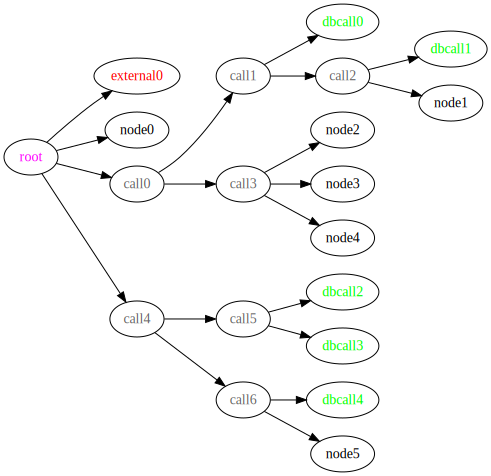

In [1]:
import numpy
from ss.mockendpoint import MockEndpoint
from ss.mocktrace import MockTrace

size_of_trace = 20

r = numpy.random.RandomState()
mepx = MockEndpoint(r, size_of_trace)
meptx = MockTrace(r, mepx)
meptx.display_graph(display_raw=True)


## Potential Shortcomings

1. How realistically shaped are these random traces? They seem pretty good around the average, at the very least? Maybe bigger-sized traces should be less deep? (that is to say, wider?)
2. The number of endpoints and datastores per trace scale as the trace size increases, but perhaps too slowly. That is to say, I suspect it might be likely that very big traces may be mostly externals or datastores called in a loop, or something like that.
3. Would the size of various "Endpoint Paths" in a microservice be correlated? My model generates the sizes independently from each other, but I'm not sure that's right.

## Experiment Results

In [18]:
%run ss/process_degradation.py

plot_degradation_results(reservoir_size=1000, sampling_target=10)
plot_degradation_results(reservoir_size=100, sampling_target=1)
plot_degradation_results(reservoir_size=100, sampling_target=10)

Figure(axes=[Axis(color='black', label='Average Trace Length', scale=LinearScale(min=0.0)), Axis(color='black'…

Figure(axes=[Axis(color='black', label='Average Trace Length', scale=LinearScale(min=0.0)), Axis(color='black'…

Figure(axes=[Axis(color='black', label='Average Trace Length', scale=LinearScale(min=0.0)), Axis(color='black'…

## Conclusion

1. It seems as though there's little value for secondary-sorting when fan-in=1, except when Reservoir Size = 100 and Sampling Target = 10.
2. However, secondary sorting rapidly becomes useful as fan-in increases. Particular of note is that at fan-in of at least 4, the percentage of full traces starts dropping sharply for microservices with average span length is around 30-35. Given the lognormal distribution estimate for span-lengths, this is approximately around the average path length for an AIM of 6-11 endpoints!
3. It is probably catastrophic to not implement some sort of secondary sort if we go to a smaller reservior-size with a faster harvest. Yikes!

## Unanswered Questions and Concerns

* How does the adaptive sampling algorithm itself affect the full-trace degradation rate? That is to say, the above experiment used a Normal distribution with a fairly tight variance for the number of sampled=True requests per fan-in, which IMHO is pretty optimistic.

* How realistic is the random trace model? It seems ok around the mid-range, but I get the feeling that bigger traces should have more externals/endpoints. That is to say, I think it would be more common that a trace of 200 spans wouldn't look so much like a big tree, but rather have some sort of loop that fires off a bunch of queries in a row. For example, we had a support ticket last week for a customer that had 26 second response times... and it was because they fired off 1001 individual elastic search queries in a row (at 22ms a piece) plus 500+ individual postgres queries.

* On one hand, actual traces generated from actual agents would be much better than these randomly generated ones. However, there's the real danger that, unless we get a huge sample size, our results may be overly representive of these particular trace types.

# Effect of Adaptive Sampling Algorithm on Full Trace Degradation Rate

## Motivation

The above plots show that the number of complete endpoint traces that an agent is able to obtain is limited by the the path length and input fan-in. The next logical followup question is: how much does the adaptive sampling algorithm matter? 

## Experiment Setup

Same as above, except this time also run the test for an adaptive sampling algorthm that's similar to the one from my other notebook. (the bayesian sampler; for simplicity, we can model it with a normal distribution of mean 10 and standard deviation log(10), which is slightly pessimistic, IMHO. )

## Experiment Results

In [17]:
%run ss/process_degradation.py

plot_comparison_degradation_results(reservoir_size=1000, sampling_target=10)

Figure(axes=[Axis(color='black', label='Average Trace Length', scale=LinearScale(min=0.0)), Axis(color='black'…

## Conclusions

The biggest effect can be seen at lower fan-in, where the more-variable sampled=True count has a bigger effect on how fast the span queue fills up. On the other hand, as fan-in rises, the independent sampled=True counts from each upstream agent add together to trend the overall count towards a normal distribution due to the central limit theorem. Thus, the uniform sampler trends towards the bayesian one.

## Unanswered Questions and Concerns

The biggest one is how much these results will change when we plug in actual per-minute sample counts into my Adaptive Sampling workbook, and then plug in those results into this experiment.

# Trace Compression Ratio

## Motivation

Some spans in the "middle" of a trace are actually redundant, and thus do not actually need to be sent to the backend in order to reconstruct the full trace. That's because if the backend has the id of a span's parent and the ids of the span's children, it can infer the existence of the span itself. Thus, we could potentially choose to not send these particular spans in order to virtually increase our reservoir capacity. Is this worth it? Who knows!

## Questions I'm Interested in:

1. How much extra virtual reservoir size (or whatever you want to call it) do we get if we go through a bunch of hoopla to compress the span reservoir?

## Pruning Visualization:

* spans determined to be "prunable" are shown with a red background
* for the exact algorithm, see the `MockSpan().mark_prunable_spans()` method.

In [ ]:
meptx.calculate_importance()
meptx.display_graph(display_raw=False, show_importance=False)

## Experiment Setup:

1. For various trace sizes, generate N random traces
2. For each trace, count the non-prunable nodes and calculate the ratio of non-prunable / total
3. Calculate the average ratio for each size

## Experiment Results:

In [ ]:
%run ss/trace_compression.py
%run ss/common.py

from ss.mockendpoint import MockEndpoint
from ss.mocktrace import MockTrace

# check which trace sizes
trace_length_options = logspace_int(10, 250, 10)

# generate multiple different trace shapes per length option
trace_variations = 20

compression_results = {}
for n in trace_length_options:
    compression_results[n] = []

    for _ in range(0, trace_variations):
        mep = MockEndpoint(r, n)
        mept = MockTrace(r, mep)
        mept.mark_prunable_spans()
        
        ratio = mept.count_nonprunable_spans() / mept.count_spans()
        compression_results[n].append(ratio)

r = numpy.random.RandomState()
plot_compression_results(trace_length_options, compression_results)

## Conclusion

Incredibly, the compression ratio is, on average, a seemingly constant value of ~0.83!! I'm really not sure what to make of this unexpected result, given these random traces are generated with highly varied shapes across a wide range of sizes!

At any rate, a compression ratio of 0.83 or whatever doesn't seem very big to me. For example, a reservoir of size 1000 only "virtually enlarges" to about size 1200. I'm not sure if it's worth doing all the extra hassle for just a 20% boost? Maybe when we move down to shorter harvests?



# Secondary Sorting Method

## Motivation

"Secondary Sorting" is a feature of the Spans MMF that aims to improve the curation of the spans events sent to the collector. In particular, when a full trace does not fit into the span event reservoir, it needs to be trimmed to fit. It's a complex operation with complex implications that operates on a complex situation in a complex environment. As such, I have no idea how to evaluate it intuitively, which is necesary to both make the best decisions for the python agent as well as give competent feedback on the spec.

Span Secondary Sorting is not yet fully defined for v1 of the spec, but it is likely to be included in v2 of the spec. Therefore, we decided to carry out an investigation as part of the spans-v1 MMF.
When a full trace does not fit into the reservoir, some of its spans need to discarded. And, since all spans of a trace have the same priority (due to spans inheriting the root's priority, which is assigned via Better-CAT v1), then the kept spans will be chosen on a first-come, first-queued order.

The problem here is that this means that if the same trace is clipped every harvest, then the same spans will be chosen to be kept every harvest, and thus a full trace of this endpoint will never be constructed. A potential solution here is adding some randomization to the selection method ensures that a full trace can eventually be pieced together on the backend. However, more randomization also means that information about more important spans (such as datastores or externals) may be rarer and less reliable.

There's probably some trade-off to be made between "time to glass for the full trace" and "time to glass for the most important spans".

## Questions I'm Interested in:

1. Will secondary-sorting with randomization piece actually together a full trace relatively quickly?
2. What sort of trade-off exists between the degree of secondary-sort randomization and how quickly the most important spans are selected? 

## Importance Scoring Visualization

Some spans, such as the root span, external spans, or datastore spans, are more important than others. Other spans, such as meaningless leaves and prunable intermediate spans, are not very important at all. The rest of the spans are somewhere in the middle. In order to sort spans by their relative importance, we have to assign them a score.

* as before, red-backgrounded spans are those determined to be prunable
* the importance score is what is listed after the span's "name"
* for the exact algorithm, please see the `MockTrace().calculate_importance` method.

In [ ]:
meptx.display_graph(display_raw=False, show_importance=True)

## Experiment Setup

1. Generate N random endpoints
2. For each endpoint, simulate it generating a trace that is clipped. Specifically, assume that some fraction of the trace is kept each harvest.
3. Determine the average number of harvests necessary to piece together a.) the most important spans (a "basic" trace), b.) the most important spans plus the ones needed to connect them together, (a "relevant" trace) and c.) a full trace of the endpoint.

## Experiment Results

In [ ]:
%run ss/ss_rate.py

# check which trace sizes
trace_length_options = logspace_int(10, 250, 10)

# generate multiple different trace shapes per length option
trace_variations = 20

# fraction of trace that fits in the reservoir
fraction_captured = linspace_fractions_noninclusive(5)

# the maximum number of harvests to try and obtain the full trace,
# before the simulation gives up
max_harvests = 100

r = numpy.random.RandomState()
plot_secondary_sort_results(r, trace_length_options, fraction_captured, max_harvests, trace_variations)

## Conclusions

1. Randomization does in fact seem to help piece together a full trace!
2. The most important spans of a trace (the yellow "basic" trace) seems to be captured very quickly.
3. The time it takes to piece together the "relevent" trace is pretty big if only a low percentage of the trace is captured each harvest, but becomes insignifcant at higher percentages. This might be relevent when we move to a shorter harvest.
4. Interestingly, increasing randomness decreases the time it takes to piece together the "relevant" and "full" traces when a low percentage of spans is captured.


## Unanswered Questions / Concerns

1. The results above are highly dependent on the number of endpoints chosen for the random traces!